In [1]:
from sb_value_function_kwargs import fc_policy_kwargs, cnn_policy_kwargs, linear_policy_kwargs
from environments.stable_baselines_env import StableBaselineEnv
from environments.stable_baselines_env_linear import StableBaselineEnvLinear
from environments.stable_baselines_env_linear_history import StableBaselineEnvLinearHistory
from environments.stable_baselines_env_history import StableBaselineEnvHistory
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

In [2]:
allocator_name = "mixed_ff_bad_wf_good"
#TODO: CHANGE BOTH POLICY KWARGS AND NET NAME
policy_kwargs = fc_policy_kwargs
net_name = "fc"
history_len = 0
env = StableBaselineEnvHistory(allocator=allocator_name, page_size=256, history_len=history_len)


model = DQN("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs, learning_rate=0.0001, device="cuda")
#model attributes
print(env.observation_space)
print(model.__dict__)

<class 'request_streams.mixed_ff_bad_wf_good.MixedFFBadWFGood'>
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Box(0, 256, (1, 257), int32)
{'policy_class': <class 'stable_baselines3.dqn.policies.DQNPolicy'>, 'device': device(type='cuda'), 'verbose': 1, 'policy_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>, 'net_arch': [32, 32]}, 'num_timesteps': 0, '_total_timesteps': 0, '_num_timesteps_at_start': 0, 'seed': None, 'action_noise': None, 'start_time': 0.0, 'learning_rate': 0.0001, 'tensorboard_log': None, '_last_obs': None, '_last_episode_starts': None, '_last_original_obs': None, '_episode_num': 0, 'use_sde': False, 'sde_sample_freq': -1, '_current_progress_remaining': 1.0, '_stats_window_size': 100, 'ep_info_buffer': None, 'ep_success_buffer': None, '_n_updates': 0, '_custom_logger': False, 'env': <stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv object at 0x000002B8FE4B16D0>, '_vec_normalize_env': None,

In [3]:
def mean_confidence_interval(data, confidence=0.95):
    n = data.shape[0]
    mean, std_err = np.mean(data), np.std(data) / np.sqrt(n)
    interval = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - interval, mean + interval, mean

Training & Rollout of policy

In [4]:
avg_return_per_session = []
action_counts_per_session = []
training_steps = 10000
for train_and_rollout in range(5):
    model.learn(total_timesteps=training_steps, log_interval=20000, progress_bar=True)
    num_actions = 3
    obs, info = env.reset()
    i = 0
    rewards = []
    curr_reward = 0
    action_counts = [0] * num_actions
    total=100
    pbar = tqdm(total = total)
    while i < total:
        action, _states = model.predict(obs, deterministic=True)
        action_counts[action] += 1
        #print(action)
        obs, reward, terminated, truncated, info = env.step(action)
        if reward != .1 and reward != 0:
            print(reward)
        #print(reward != 1)
        curr_reward += reward
        if terminated or truncated:
            pbar.update(1)
            obs, info = env.reset()
            i += 1
            rewards.append(curr_reward)
            curr_reward = 0

    print(np.mean(rewards))
    avg_return_per_session.append(np.mean(rewards))
    action_counts_per_session.append(action_counts)

model_conf_int = mean_confidence_interval(np.array(avg_return_per_session))
model_conf_int = np.array(model_conf_int)

print(f"Model confidence interval: {model_conf_int}")

action_counts_per_session = np.array(action_counts_per_session)
action_counts_per_session = np.sum(action_counts_per_session, axis=0)
action_counts_per_session = action_counts_per_session / np.sum(action_counts_per_session)

plt.bar(np.arange(3), action_counts_per_session)
plt.title(f"High-level action frequences of using {net_name} network and history len {history_len} on {allocator_name} allocator")
plt.xticks(np.arange(3), ["best fit", "worst fit", "first fit"])

Output()

100%|██████████| 100/100 [00:15<00:00,  6.89it/s]

Output()

16.81600000000002


100%|██████████| 100/100 [00:38<00:00,  2.60it/s]


Output()

16.424000000000028


100%|██████████| 100/100 [00:21<00:00,  3.87it/s]

Output()

18.978000000000034


100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


Output()

22.251000000000055


KeyboardInterrupt: 

Baselines (best fit, worst fit, first fit)

In [ ]:
conf_ints_baselines = []
for allocator in tqdm(range(3)):
    obs, info = env.reset()
    i = 0
    rewards = []
    curr_reward = 0
    while i < 100:
        #action, _states = model.predict(obs, deterministic=True)
        #print(action)
        obs, reward, terminated, truncated, info = env.step(allocator)
        if reward != .1 and reward != 0:
            print(reward)
        #print(reward != 1)
        curr_reward += reward
        if terminated or truncated:
            obs, info = env.reset()
            i += 1
            rewards.append(curr_reward)
            curr_reward = 0

    #print(allocator, mean_confidence_interval(np.array(rewards)))

    conf_ints_baselines.append(mean_confidence_interval(np.array(rewards)))

print(conf_ints_baselines)
conf_ints_baselines = np.array(conf_ints_baselines)
    

100%|██████████| 3/3 [00:02<00:00,  1.27it/s]

[(3.880912850257867, 7.375087149742153, 5.62800000000001), (4.453532451100916, 8.088467548899112, 6.271000000000014), (0.9577644718435908, 1.20423552815641, 1.0810000000000004)]


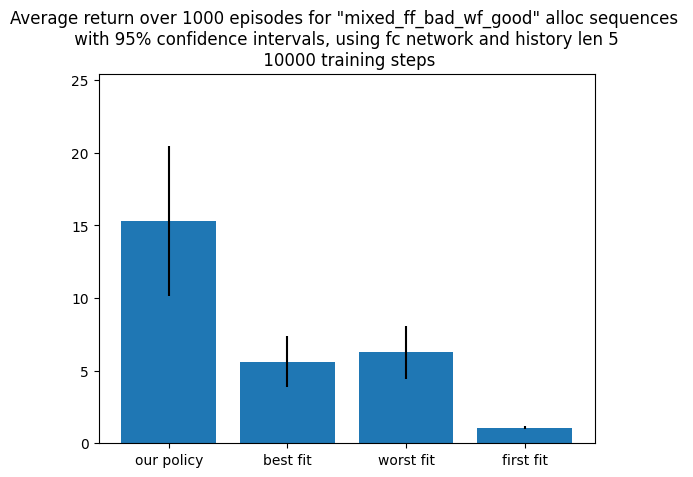

In [ ]:
#create a bar graph with the confidence intervals
import os
all_conf_ints = np.vstack((model_conf_int, conf_ints_baselines))

plt.bar(x=np.arange(4), height=all_conf_ints[:,2], yerr=all_conf_ints[:, 2] - all_conf_ints[:, 0])
plt.title(f"Average return over 1000 episodes for \"{allocator_name}\" alloc sequences \n with 95% confidence intervals, using {net_name} network and history len {history_len} \n {training_steps} training steps")
plt.xticks(np.arange(4), ["our policy", "best fit", "worst fit", "first fit"])

out_dir = f"results/{allocator_name}"
os.makedirs(out_dir, exist_ok=True)
plt.ylim(top=max(all_conf_ints[:,1]) + 5)
plt.savefig(os.path.join(out_dir, f"{allocator_name}_{net_name}_{history_len}_{training_steps}.png"), bbox_inches = "tight")
np.savetxt(os.path.join(out_dir, f"{allocator_name}_{net_name}_{history_len}_{training_steps}.txt"), all_conf_ints) #in order of model, best fit, worst fit, first fit